In [36]:
import torch
from torch import nn
import random
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.9.1+cu128'

In [37]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [38]:
# Dataset path
train_dir = "./data/training_set/training_set"
test_dir = "./data/test_set/test_set"
train_dir, test_dir

('./data/training_set/training_set', './data/test_set/test_set')

Random image path: ./data/training_set/training_set/cats/cat.2254.jpg
Image class: cats
Image height: 354
Image width: 373


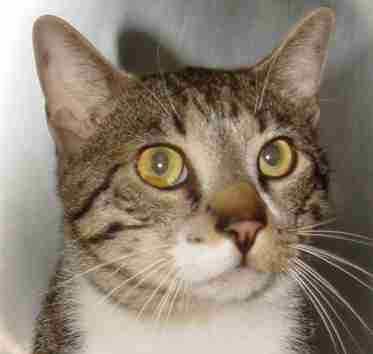

In [39]:
import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(0)

# 2 random image path
random_image_path = './data/training_set/training_set/cats/cat.2254.jpg'

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [40]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_WIDTHxIMAGE_HEIGHT
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

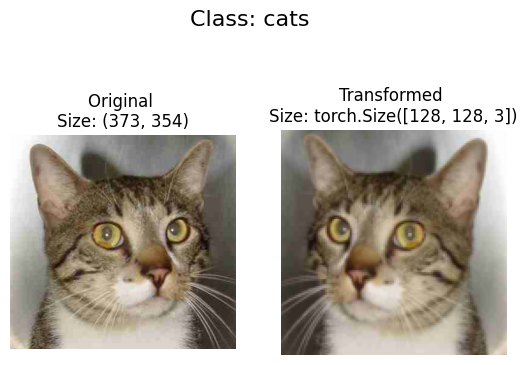

In [41]:
def plot_transformed_images(image_path, transform):
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")
        fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)

plot_transformed_images(random_image_path, transform=data_transform)

In [42]:
from torchvision import datasets

# Load training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
# Load test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: ./data/training_set/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: ./data/test_set/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [43]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['cats', 'dogs']
Class names as a dict:  {'cats': 0, 'dogs': 1}
The lengths of the training and test sets:  8005 2023


Turn loaded images into DataLoader

In [45]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # samples per batch
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff7d5476720>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff7d5a06090>)

In [46]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [47]:
# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [48]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: ./data/training_set/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: ./data/test_set/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [49]:
# Set some parameters.
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7ff7d559e390>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff7d559f890>)

In [50]:
# Creating a CNN image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = ImageClassifier().to(device)

In [51]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0116, -0.0099]])

Output prediction probabilities:
tensor([[0.4996, 0.5004]])

Output prediction label:
tensor([1])

Actual label:
1


In [53]:
# Function to train the model
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [54]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [55]:
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
# Create a SummaryWriter to log metrics for TensorBoard
writer = SummaryWriter()

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Optionally log the model graph (best-effort)
    try:
        sample_batch = next(iter(train_dataloader))[0].to(device)
        writer.add_graph(model, sample_batch)
    except Exception:
        # Graph logging can fail depending on the model/input; ignore if it does
        pass

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. Log scalars to TensorBoard for this epoch
        try:
            writer.add_scalar('train/loss', train_loss, epoch)
            writer.add_scalar('train/accuracy', train_acc, epoch)
            writer.add_scalar('test/loss', test_loss, epoch)
            writer.add_scalar('test/accuracy', test_acc, epoch)
            # also log learning rate if optimizer has param_groups
            if hasattr(optimizer, 'param_groups') and len(optimizer.param_groups) > 0:
                lr = optimizer.param_groups[0].get('lr', None)
                if lr is not None:
                    writer.add_scalar('train/learning_rate', lr, epoch)
            writer.flush()
        except Exception:
            pass

    # 7. Close the writer and return results
    try:
        writer.close()
    except Exception:
        pass
    return results

Train and evaluate model

In [56]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0245 | train_acc: 0.5567 | test_loss: 0.7058 | test_acc: 0.6283
Epoch: 2 | train_loss: 0.8024 | train_acc: 0.6144 | test_loss: 0.6455 | test_acc: 0.6556
Epoch: 2 | train_loss: 0.8024 | train_acc: 0.6144 | test_loss: 0.6455 | test_acc: 0.6556
Epoch: 3 | train_loss: 0.7169 | train_acc: 0.6636 | test_loss: 0.5900 | test_acc: 0.6579
Epoch: 3 | train_loss: 0.7169 | train_acc: 0.6636 | test_loss: 0.5900 | test_acc: 0.6579
Epoch: 4 | train_loss: 0.6019 | train_acc: 0.6950 | test_loss: 0.5431 | test_acc: 0.7280
Epoch: 4 | train_loss: 0.6019 | train_acc: 0.6950 | test_loss: 0.5431 | test_acc: 0.7280
Epoch: 5 | train_loss: 0.5338 | train_acc: 0.7361 | test_loss: 0.5999 | test_acc: 0.7179
Epoch: 5 | train_loss: 0.5338 | train_acc: 0.7361 | test_loss: 0.5999 | test_acc: 0.7179
Epoch: 6 | train_loss: 0.5033 | train_acc: 0.7547 | test_loss: 0.4747 | test_acc: 0.7638
Epoch: 6 | train_loss: 0.5033 | train_acc: 0.7547 | test_loss: 0.4747 | test_acc: 0.7638
Epoch: 7 | train_loss

Plot the loss curves of the model

In [57]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

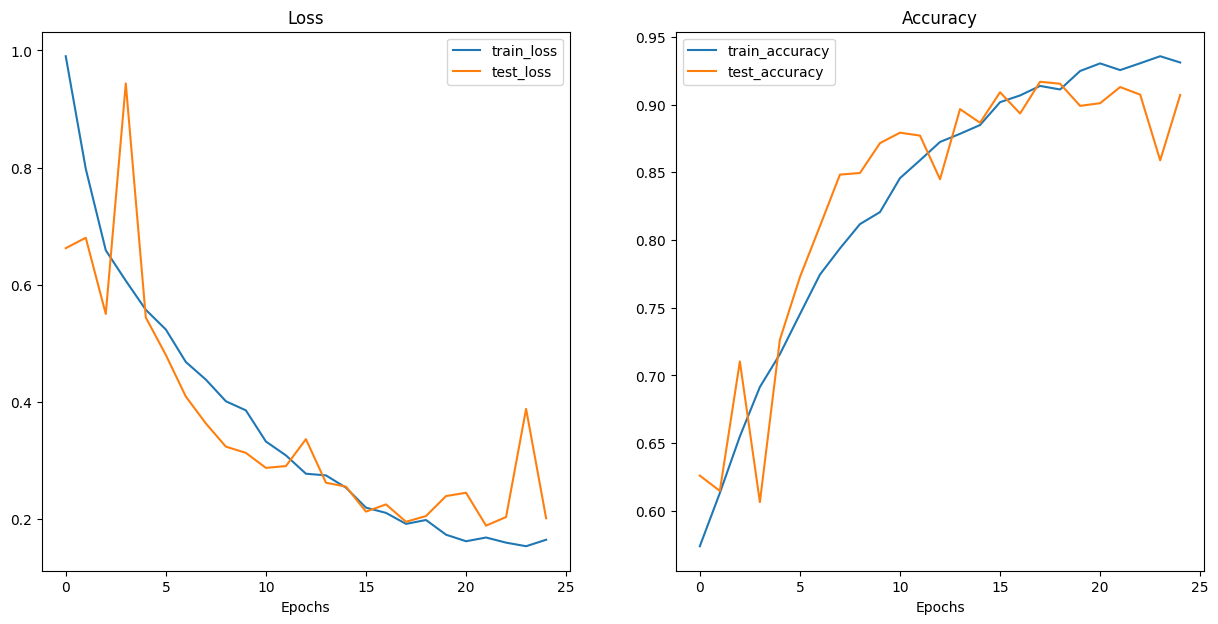

In [22]:
plot_loss_curves(model_results)

Save model

In [58]:
torch.save(model.state_dict(), "./pytorch_models/cat_and_dog_weights_1.pth")

Load saved model

In [59]:
loaded_model = ImageClassifier()  #
loaded_model.load_state_dict(torch.load("./pytorch_models/cat_and_dog_weights_1.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Image Class: dogs
Predicted Label Index: 1
Predicted Class: dogs
Prediction Probabilities: [0.02107909321784973, 0.9789208769798279]


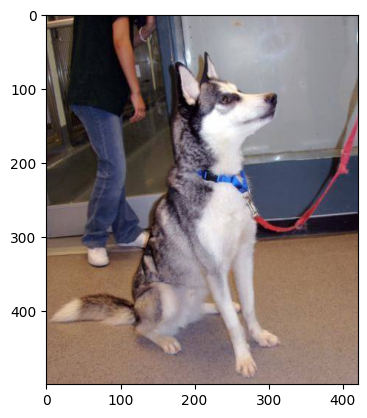

In [60]:
random_image_path = './data/test_set/test_set/dogs/dog.4001.jpg'

# Get image class from path name
image_class = Path(random_image_path).parent.stem

# Open image
img = Image.open(random_image_path)

# Visualize image
plt.imshow(img)

# Apply test_transform and add batch dimension
input_image = test_transform(img).unsqueeze(0)

# Make prediction
loaded_model.eval()
with torch.inference_mode():
    prediction_logits = loaded_model(input_image)

# Convert logits to prediction probabilities and then to predicted label
prediction_probs = torch.softmax(prediction_logits, dim=1)
predicted_label = torch.argmax(prediction_probs, dim=1).item()

print(f"Image Class: {image_class}")
print(f"Predicted Label Index: {predicted_label}")
print(f"Predicted Class: {class_names[predicted_label]}")
print(f"Prediction Probabilities: {prediction_probs.squeeze().tolist()}")